In [3]:
"""Plot the pickles produced by poster_astrometry.py
"""
from pathlib import Path
import os
import pickle

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn
seaborn.set_style('white')  # noqa: E402
seaborn.set_context("poster")  # noqa: E402
import itertools

In [4]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def colorbar(mappable):
     """Create a colorbar that obeys tight_layout, etc.

     Stolen from: http://joseph-long.com/writing/colorbars/

     Parameters
     ----------
     mappable
         Return value from e.g. `matplotlib.imshow()` or `matplotlib.scatter()`.
     """
     try:
         # QuadContourSet is not a Artist, so doesn't have `axes`
         ax = mappable.axes
     except AttributeError:
         ax = mappable.ax
     fig = ax.figure
     divider = make_axes_locatable(ax)
     cax = divider.append_axes("right", size="5%", pad=0.05)
     return fig.colorbar(mappable, cax=cax)

In [5]:
def uv_mean(xlim, ylim, xx, yy, uu, vv, nx, ny):
    """Compute the mean of uu and vv on a grid within bbox."""
    #ny = int(nx*(ylim[1]-ylim[0]) / (xlim[1]-xlim[0]))    NEEDS WORK FOR ROTATED CCDs
    uMean = np.zeros((nx-1, ny-1))
    vMean = np.zeros((nx-1, ny-1))
    xMean = np.zeros((nx-1, ny-1))
    yMean = np.zeros((nx-1, ny-1))
    ww = np.linspace(xlim[0], xlim[1], nx)
    hh = np.linspace(ylim[0], ylim[1], ny)
    xrange = np.array([((xx >= w0) & (xx <= w1)) for w0, w1 in zip(ww[:-1], ww[1:])], dtype=bool)
    yrange = np.array([((yy >= w0) & (yy <= w1)) for w0, w1 in zip(hh[:-1], hh[1:])], dtype=bool)
    for i, (w0, w1) in enumerate(zip(ww[:-1], ww[1:])):
        for j, (h0, h1) in enumerate(zip(hh[:-1], hh[1:])):
            inside = xrange[i] & yrange[j]
            xMean[i, j] = (w0 + w1)/2
            yMean[i, j] = (h0 + h1)/2
            uMean[i, j] = np.mean(uu[inside]) #np slicing 
            vMean[i, j] = np.mean(vv[inside])

    return xMean, yMean, uMean, vMean


def plot_quiver(xx, yy, uu, vv, ccd, label):
    """Make a quiver plot of the astrometry error vectors."""
    cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

    color = cycle[0] if 'jointcal' in label else cycle[1]
    scale = 0.005 if 'mean' in label else 1
    
    x_size = 10*(xx.max()-xx.min()) / (yy.max()-yy.min())
    fig = plt.figure(figsize=(x_size, 10)) 
    ax = fig.add_subplot(111)
    
    cmap = ListedColormap(seaborn.color_palette('husl').as_hex())
    
    angle = np.nan_to_num(np.arctan2(vMean,uMean))
    Q = ax.quiver(xx, yy, uu, vv, angle, cmap=cmap, units='x', pivot='tail', scale=scale, width=10,
                  headwidth=4, clip_on=False)
    #Q = ax.quiver(xx, yy, uu, vv, units='x', pivot='tail', scale=scale, width=7,
    #              headwidth=4, clip_on=False, color=color)
    length = 5/scale if 'mean' in label else 100
    key = ax.quiverkey(Q, 0.175, 0.15, length, '%s mas'%(length), angle=45,
                       coordinates='figure', labelpos='W', fontproperties={'size': 24})

    #ax.set_xticklabels([])
    #ax.set_yticklabels([])
    fig.subplots_adjust()
    plt.show();

    filename = Path("plots/quiver-%s-%s.png"%(ccd, label))
#    plt.savefig(filename, bbox_extra_artists=(key,))# bbox_inches="tight")
#    plt.close(fig)

# Full focal plane load-in

In [6]:
import glob

name = 'jointcal'
pattern = os.path.abspath('focalplane/%s/pickles/quiverData-%s-*.pickle'%(name, name))
files = glob.glob(pattern)

xMean = yMean = uMean = vMean = None
for file in files:
    with open(os.path.expanduser(file), 'rb') as infile:
        xx, yy, uu, vv, xlim, ylim, ccd = pickle.load(infile)
        xTemp, yTemp, uTemp, vTemp = uv_mean(xlim, ylim, xx, yy, uu, vv, 10, 20)
        if xMean is None:
            xMean = xTemp
            yMean = yTemp
            uMean = uTemp
            vMean = vTemp
        else:
            xMean = np.vstack((xMean, xTemp))
            yMean = np.vstack((yMean, yTemp))
            uMean = np.vstack((uMean, uTemp))
            vMean = np.vstack((vMean, vTemp))

C:\Users\Short Stack\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Short Stack\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


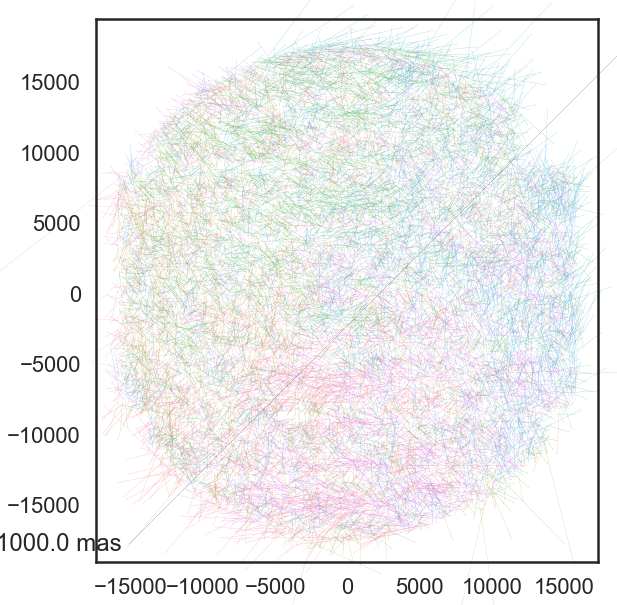

In [7]:
#plot_quiver(xx, yy, uu, vv, ccd, name)

plot_quiver(xMean, yMean, uMean, vMean, ccd, 'mean-'+name)

In [8]:
#%timeit uv_mean(xlim, ylim, xx, yy, uu, vv, 30, 60)

In [9]:
#%timeit uv_mean(xlim, ylim, xx, yy, uu, vv, 30, 60)

-Reproduce in bokeh (and matplotlib {sliders??}) 



In [10]:
from bokeh.layouts import gridplot
from bokeh.plotting import figure, show, output_file
from bokeh.models import ColumnDataSource, ColorBar, tools
import bokeh.palettes as palettes 
from bokeh.transform import linear_cmap
import astropy.units as u

#import holoviews as hv

In [11]:
arcsecperpix = .17

def bokeh_qplot(xx, yy, uu, vv):
    """
    Bokeh Quiver plot using segment()
    Inputs:
    xx,yy positions and uu,vv vector points
    Outputs:
    vectors at positions xx,yy with the ability 
    to view each vector's angle, length and 
    begining and end position on the x-y plane  
    """
    #data for plot
    x0 = xMean.flatten()
    y0 = yMean.flatten()
    length = np.nan_to_num(np.sqrt(uMean**2 + vMean**2)) * u.arcsec
    angle = np.nan_to_num(np.arctan2(vMean,uMean))
    angle_deg = angle*180/np.pi
    
    x1 = (xMean + length.value/arcsecperpix * np.cos(angle)).flatten()
    y1 = (yMean + length.value/arcsecperpix * np.sin(angle)).flatten()

    slopes = []
    for i in range(len(x0)):
        m = (y1[i]-y0[i])/(x1[i]-x0[i])
        slopes.append(m)

    #line coloring
    pal = seaborn.color_palette('husl', 21).as_hex() #palettes.'palette name'('number of colors') if using bokeh.pallets
    cm = np.array(pal) 
    ix = ((angle-angle.min())/(angle.max()-angle.min())*20).astype('int') #normalizing 
    colors = cm[ix].flatten()

    #data frame setup for hover tool
    source = ColumnDataSource(data={
        'x0'     : x0,
        'y0'     : y0,
        'x1'     : x1,
        'y1'     : y1,
        'slopes' : np.asarray(slopes),
        'angle'  : np.asarray(angle* 180/np.pi),
        'length' : np.asarray(length),
        'color'  : np.asarray(colors)
    })
    TOOLTIPS = [
        ("(x0,y0)", "(@x0{1.11}, @y0{1.11})"), #{1.11} formats as 2 decimal float
        ("(x1,y1)", "(@x1{1.11}, @y1{1.11})"),
        ("Length", "@length{%s}"), ###get astropy.units to print out
        ("Angle (deg)", "@angle{1.111}"),
    ]
    hover = tools.HoverTool(
        tooltips = TOOLTIPS,
        formatters = {
            "length" : "printf"
        }

    )

    p1 = figure( title="%s Data"%name)
    p1.title.text_font_size = "50px"
    p1.add_tools(hover)
    p1.segment('x0', 'y0', 'x1', 'y1', color='color', line_width=2, source=source, legend='unit')

    mapper = linear_cmap(field_name='angle', palette=pal ,low=min(angle_deg.flatten()) ,high=max(angle_deg.flatten()))
    color_bar = ColorBar(color_mapper=mapper['transform'], width=12,  location=(0,0))

    p1.add_layout(color_bar, 'right')

    output_file("BokehSegmentVector.html", title="BokehSegmentVector (%s)"%name)

    show(p1) 

In [12]:
#print(hv['twilight_shifted'][11])

In [96]:
bokeh_qplot(xMean, yMean, uMean, vMean)

C:\Users\Short Stack\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars


-Cyclic Bokeh colormap 

-legend (with actual unit size) {Cant find anything that can do this???}


# Divergence

In [21]:
def plot_divergence(xMean, yMean, uMean, vMean):
    uDel = np.nan_to_num(np.gradient(uMean))
    vDel = np.nan_to_num(np.gradient(vMean))
    divergence = uDel[1]+vDel[0] #dudx+dvdy

    plt.figure(figsize=(10,10))
    plt.title('Divergence (Full Focal Plane)')

    div_plot = plt.scatter(xMean.flatten(), yMean.flatten(),vmin=-10 ,vmax=10, c=divergence.flatten(), s=5, cmap="plasma")

    colorbar(div_plot);
def plot_curl(xMean, yMean, uMean, vMean):
    uDel = np.nan_to_num(np.gradient(uMean))
    vDel = np.nan_to_num(np.gradient(vMean))
    curl = vDel[1]-uDel[0] #dvdx-dudy

    plt.figure(figsize=(10,10))
    plt.title('Curl (Full Focal Plane)')

    curl_plot = plt.scatter(xMean.flatten(), yMean.flatten(),vmin=-10 ,vmax=10, c=curl.flatten(), s=5, cmap="plasma")

    colorbar(curl_plot);

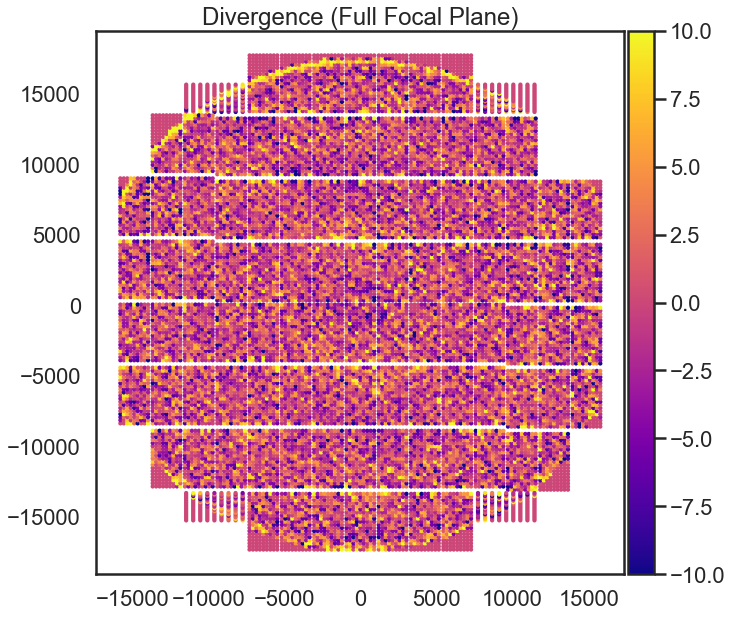

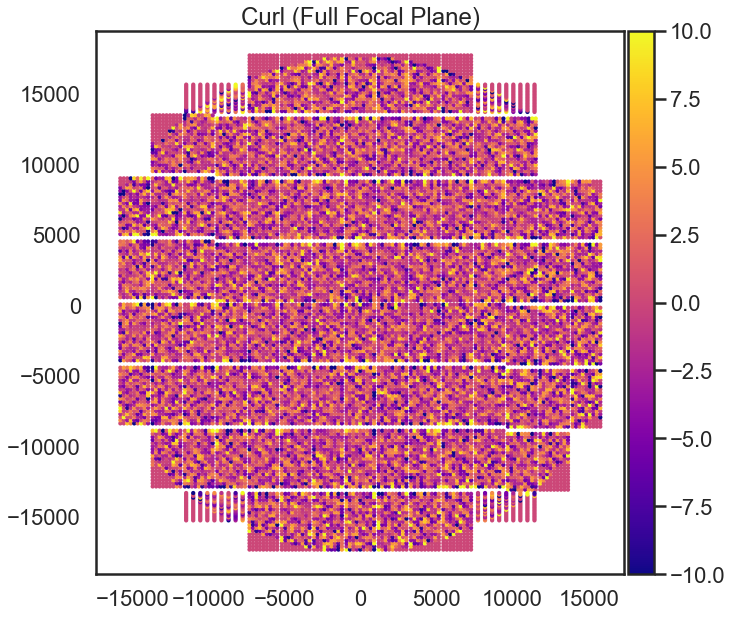

In [22]:
plot_divergence(xMean, yMean, uMean, vMean)
plot_curl(xMean, yMean, uMean, vMean)

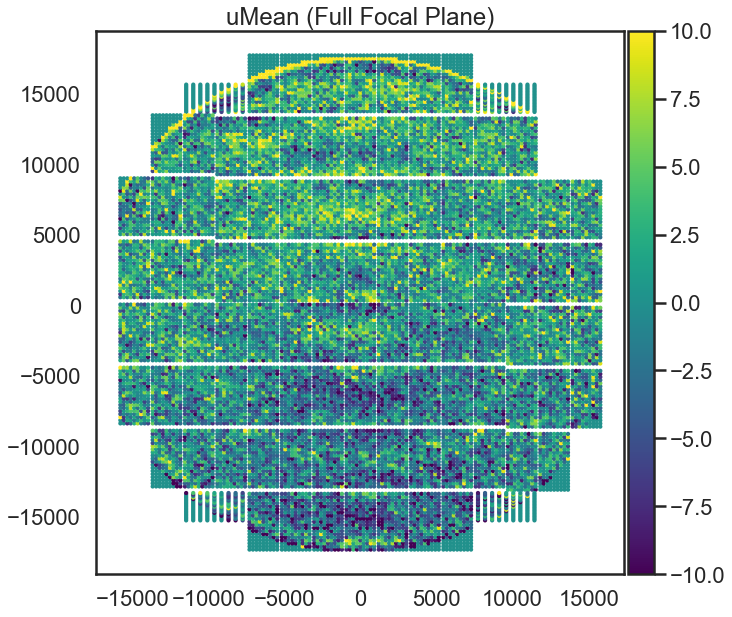

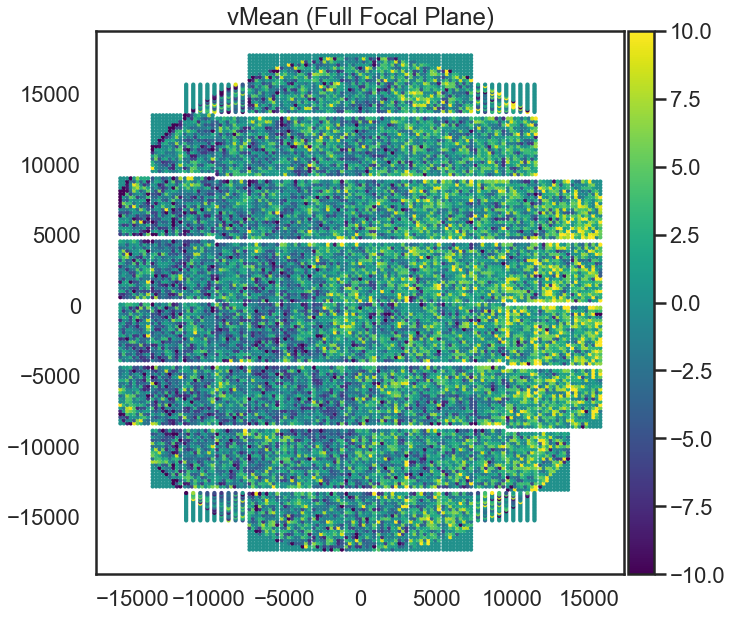

In [15]:
plt.figure(figsize=(10,10))
plt.title('uMean (Full Focal Plane)')
plot1 = plt.scatter(xMean.flatten(), yMean.flatten(),vmin=-10,vmax=10 ,s=5, c=np.nan_to_num(uMean.flatten()), cmap='viridis')
colorbar(plot1);

plt.figure(figsize=(10,10))
plt.title('vMean (Full Focal Plane)')
plot2 = plt.scatter(xMean.flatten(), yMean.flatten(),vmin=-10,vmax=10 ,s=5, c=np.nan_to_num(vMean.flatten()), cmap='viridis')
colorbar(plot2);

#3d scatter plot

In [ ]:
#duplicate all plots using single frame data
